# Dependence of stock market value on Donald Trump's tweets

This notebook shows a project which calculates a linear regression coefficienct describing the dependence of the S&P500 stock market daily closing value as a function of the number of keywords tweeted (in this case by Donald Trump) in the timeframe before the daily close.

Using selenium, data is scraped from Twitter for the usename provided, and the closing price of the day (sometimes 'None' on weekends or holidays) is scraped from the website "https://www.marketwatch.com/investing/index/spx/historical".  Data is saved to a 'csv' file.  If a csv file with the correct name already exists, the scraping is skipped and the correct 'csv' file is imported.  Twitter only allows viewing through last November (for Donald Trump's account), so that is where this study starts and it ends on March 24, 2018.

The historical S&P500 index as a function of date, scraped from the website, is shown below: 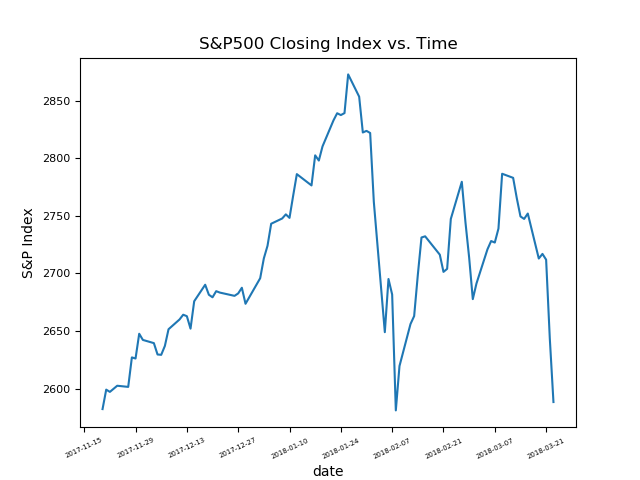

The script takes 2 arguments, a twitter username and a text file which has keywords related to a certain topic.  For instance, the script "Russia.txt" has the following text:

Russia \n
Putin \n
Mueller \n
collusion \n
investigation \n

The script counts the number of keywords in a timeframe between stock market closing times.  A regression analysis is then performed on the S&P500 index as a function of the number of keywords in a time period.  The regression coefficient for the "Russia.txt" keywords from Nov 17, 2017, to March 24, 2018 was r = -0.868.  The regression coefficient for the single word "tax" was r = 2.7; when adding the word "tariff" (so both tax and tariff are counted), the regression coefficient becomes negative, with a value of r = -0.279.  The scatterplots and fitted lines for "Russia.txt" and the word "tax" are shown below:

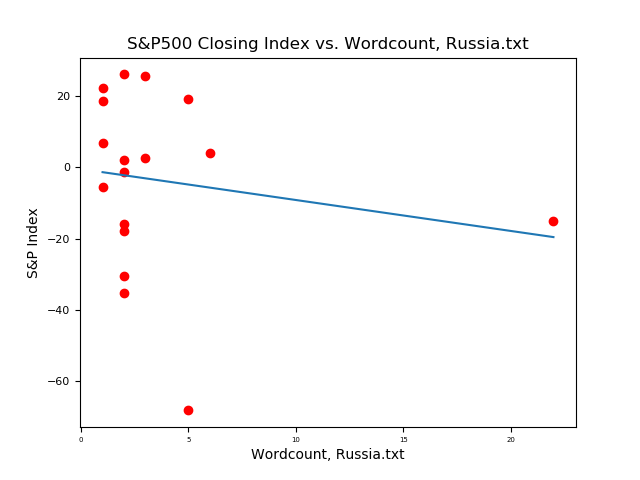
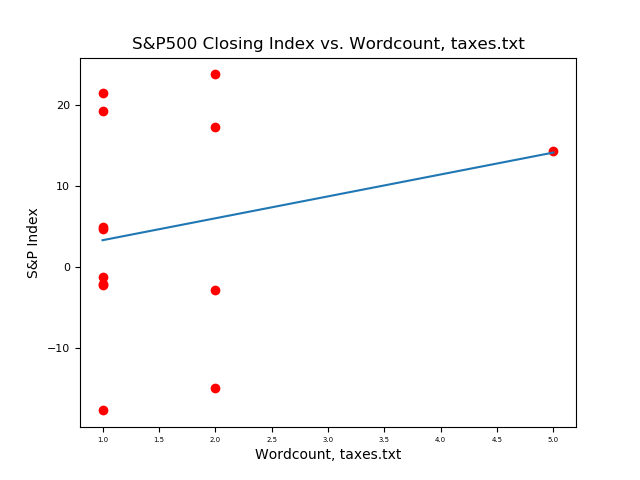

The code for the full script is shown below.

In [ ]:
# %load /Users/tesjohns/PythonGoogleClass/GetTweets/Analyze_DTtweets_SandP500.py
import numpy as np
import time, os, sys, re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import datetime
from operator import methodcaller
import matplotlib.pyplot as plt
plt.rc('ytick', labelsize=8)
plt.rc('xtick', labelsize=5)
#import matplotlib.dates as mdates

def GetTweets(twitterAccount):
    browser = webdriver.Chrome()
    base_url=u'https://twitter.com/' + twitterAccount
    query=u''
    url = base_url + query

    browser.get(url)
    time.sleep(1)

    body = browser.find_element_by_tag_name('body')
    
    for _ in range(1000):
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.2)
        
    timestamps = browser.find_elements_by_class_name('tweet-timestamp')
    tweets = browser.find_elements_by_class_name('js-tweet-text')
        
    if len(timestamps) != len(tweets):
        print 'timestamps and tweets are different lengths.'
        exit(0)
        
    tweetString = []
    datesString = []
    set = []
    for i in range(0,len(tweets)):
        tweetString.append(tweets[i].text)
        datesString.append(timestamps[i].text)
        
    tweets_dates = list(zip(tweetString, datesString))
    tweetData = pd.DataFrame(data = tweets_dates, columns=['Tweet','Date'])
    outfilename = twitterAccount + '_Tweets.csv'
    tweetData.to_csv(outfilename,  encoding='utf-8', index=False)
    
    
def GetSandP500Data():

    # Get list of dates for study
    datelist = pd.Series(pd.date_range(end=pd.Timestamp('now'), periods=127))
    dates = datelist.map(methodcaller('strftime', '%d/%m/%Y'))

    # start web driver
    driver = webdriver.Chrome()

    SandP_close = []
    date_list = []
    count = -1
    for date in dates:
        count += 1    
        enter_date = date[3:5] + "/" + date[0:2] + "/" + date[6:]

        if os.path.isfile('SandP.txt'):
            f = open('SandP.txt', 'r')
            
            searchstring = '(.+)\t(%s)' % (date)
            searchstringfound = re.findall(searchstring, f.read())
            if searchstringfound: 
                SandP_close.append(searchstringfound[0][0])
                date_list.append(searchstringfound[0][1])
                continue
            f = open('SandP.txt', 'a+')
        else:
            f = open('SandP.txt', 'a+')

        # open web browser to retrieve historical web S&P indices
        driver.get("https://www.marketwatch.com/investing/index/spx/historical")
        elem = driver.find_element_by_id("quotedate")
        elem.send_keys(enter_date)
        WebDriverWait(driver, 50).until(EC.visibility_of_element_located((By.ID, 'datebutton'))).click()
        #driver.find_element_by_id('datebutton').click()
        
        elem2 = driver.find_element_by_id('quotedata')
        waitstring  = datetime.date(1900, int(dates[count][3:5]), 1).strftime('%B') + ' ' + dates[count][0:2] 
        print datelist[count].weekday()
        if datelist[count].weekday() < 5:
            try:
                element = WebDriverWait(driver, 40).until(
                    EC.text_to_be_present_in_element((By.ID, "quotedata"), waitstring)
                    )
            except:
                print "time out"
                filestring = ("%s\t%s\n" % (SandP_close.append(SandP_close[len(SandP_close)-1]), date))
                f.write(filestring)
                SandP_close.append(SandP_close[len(SandP_close)-1])
                date_list.append(date)


            elem2 = driver.find_elements_by_tag_name("img")
            gotmatch = 0
            for image in elem2:
                imagesrc = image.get_attribute("src")
                match = re.search("countrycode", imagesrc)
                if match:
                    backward_price = imagesrc[-8:]
                    front_price = backward_price[::-1]
                    front_price = re.sub(',', '', front_price)
                    front_price = float(front_price)
                    #print 'price = %f' % (front_price) 
                    if not front_price:
                        filestring = ("%s\t%s\n" % (SandP_close.append(SandP_close[len(SandP_close)-1]), date))
                        f.write(filestring)
                        SandP_close.append(SandP_close[len(SandP_close)-1])
                        date_list.append(date)
                    else:
                        filestring = ("%s\t%s\n" % (front_price, date))
                        f.write(filestring)
                        SandP_close.append(front_price)
                        date_list.append(date)
                    gotmatch = 1
                    break
            if gotmatch == 0:
                filestring = ("%s\t%s\n" % (SandP_close.append(SandP_close[len(SandP_close)-1]), date)) 
                f.write(filestring)
                SandP_close.append(SandP_close[len(SandP_close)-1])
                date_list.append(date)
        else:
            if count < 2:
                count = count - 1
                continue
            else:
                filestring = ("%s\t%s\n" % (SandP_close.append(SandP_close[datelist[count].weekday()-1]), date))
                f.write(filestring)
                SandP_close.append(SandP_close[datelist[count].weekday()-1])
                date_list.append(date)

    SlopeList = []            
    for i in range(0,len(date_list)):
        if i == len(date_list)-1:
            SlopeList.append('None')
        if SandP_close[i] == 'None':
            SlopeList.append('None')
        else:
            for j in range(1, 10):
                if i+j < len(date_list)-1:
                    if SandP_close[i+j] != 'None':
                        SlopeList.append(str(float(SandP_close[i+j]) - float(SandP_close[i])))
                        break

    #print 'len SandP_close = %d, len SlopeList = %d' % (len(SandP_close), len(SlopeList))
    SandP_dates = list(zip(SandP_close, SlopeList, date_list))
    SandP_Dates_Data = pd.DataFrame(data = SandP_dates, columns=['Closing_Price','Slope', 'Date'])
    outfilename = 'SandP500.csv'
    SandP_Dates_Data.to_csv(outfilename,  index=False, header=True, encoding='utf-8')

    # plot the S&P500 index over time
    SandP_Dates_Data.Date = pd.to_datetime(SandP_Dates_Data.Date, dayfirst=True)
    SandP_Dates_Data_noNone = SandP_Dates_Data[SandP_Dates_Data.Closing_Price.str.contains("None") == False]
    SandP_Dates_Data_noNone.Closing_Price = SandP_Dates_Data_noNone.Closing_Price.astype(float)

    plt.plot(SandP_Dates_Data_noNone.Date, SandP_Dates_Data_noNone.Closing_Price)
    plt.ylabel(r'$\ln\left(\frac{x_a-x_b}{x_a-x_c}\right)$')
    plt.xlabel(r'$\ln\left(\frac{x_a-x_d}{x_a-x_e}\right)$')
    plt.xlabel('date')
    plt.ylabel('S&P Index')
    plt.xticks(rotation=25)
    plt.title('S&P500 Closing Index vs. Time')
    #plt.locator_params(axis='y', nbins=4)
    #plt.show()
    plt.savefig('SandP_ClosingIndex_vsTime.png')
    return SandP_Dates_Data


def FindWordCount_byDate(csvfile, wordcount_file):
    Tweets = pd.read_csv(csvfile, usecols=['Tweet', 'Date'], index_col=False)
    #print Tweets
    tweetList = Tweets['Tweet'].tolist()
    dateList = Tweets['Date'].tolist()
    
    f = open(wordcount_file, 'r')
    wordlist = []
    for word in f:
        print 'word = ', word
        wordlist.append(word.rstrip())

    print wordlist
    months = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}
    wordDict = {}

    for i in range(0, len(tweetList)):
        if re.search('hour', dateList[i]):
            #print 'tweetList[%d] = %s' % (i, dateList[i])
            continue
        else:
            if len(dateList[i]) < 7:
                date = '%s/%s/%s' % (dateList[i][:-4],months[dateList[i][-3:]],'2018')
                #print 'date = %s' % (date)
            else:
                date = '%s/%s/20%s' % (dateList[i][:-7],months[dateList[i][-6:-3]],dateList[i][-2:])
                #print 'date = %s' % (date)
            #if dictionary value for this word does not exist, create it 
            if date not in wordDict:
                wordDict[date] = 0
            for word in wordlist:
                matches = re.findall(r'%s'.lower() % (word), r'%s'.lower() % (tweetList[i]))
                if matches:
                    wordDict[date] = wordDict[date] + len(matches)

    # Check if dict is being filled correctly
    '''
    for key in sorted(wordDict.keys()):
        if wordDict[key] > 0:
            print 'key = %s, value = %d' % (key, wordDict[key])
    '''
    # make a pandas DataFrame with the dict
    Tweet_wordValues = pd.DataFrame(wordDict.items(), columns=['Date', 'wordValue'])
    #print Tweet_wordValues
    return Tweet_wordValues
        
def Compare_Tweets_To_SandP(Tweet_Wordcount, wordcount_file):
    wordValue_tweetsList = Tweet_Wordcount['wordValue'].tolist()
    date_tweetsList = Tweet_Wordcount['Date'].tolist()

    SandP_Values = pd.read_csv('SandP500.csv', usecols=['Closing_Price', 'Slope',  'Date'], index_col=False)
    #print SandP_Values

    slopeList = SandP_Values['Slope'].tolist()
    dateList = SandP_Values['Date'].tolist()
    wordCountList = []

    # joining list by hand.  One day I'll learn the efficient way to do this.
    wordCount = 0
    for i in range(0,len(slopeList)):
        for j in range(0,len(date_tweetsList)):
            if date_tweetsList[j] == dateList[i]:
                wordCount += wordValue_tweetsList[j]
        if slopeList[i] != "None":
            wordCountList.append(wordCount)
            wordCount = 0
        else:
            wordCountList.append("None")
        if wordCountList[i] == 20:
            print dateList[i]
    #print wordCountList
    #print 'len(wordCountList) = %s, len(slopeList) = %s' % (len(wordCountList), len(slopeList))

    # make new DataFrame
    slope_wordcount = list(zip(wordCountList, slopeList))
    slope_wordcount_Data = pd.DataFrame(data = slope_wordcount, columns=['Wordcount', 'SandP500_Slope'])    
    slope_wordcount_Data_noNone = slope_wordcount_Data[slope_wordcount_Data.SandP500_Slope.str.contains("None") == False]
    slope_wordcount_Data_noNone_noZeros = slope_wordcount_Data_noNone[slope_wordcount_Data_noNone.Wordcount != 0]

    #print slope_wordcount_Data_noNone_noZeros
    slope_wordcount_Data_noNone_noZeros = slope_wordcount_Data_noNone_noZeros.astype(float)

    plt.plot(slope_wordcount_Data_noNone_noZeros.Wordcount, slope_wordcount_Data_noNone_noZeros.SandP500_Slope, 'ro')
    plt.ylabel(r'$\ln\left(\frac{x_a-x_b}{x_a-x_c}\right)$')
    plt.xlabel(r'$\ln\left(\frac{x_a-x_d}{x_a-x_e}\right)$')
    plt.xlabel('Wordcount, %s'% (os.path.basename(wordcount_file)))
    plt.ylabel('S&P Index')
    plt.title('S&P500 Closing Index vs. Wordcount, %s' % (os.path.basename(wordcount_file)))
    plt.plot(np.unique(slope_wordcount_Data_noNone_noZeros.Wordcount), np.poly1d(np.polyfit(slope_wordcount_Data_noNone_noZeros.Wordcount, slope_wordcount_Data_noNone_noZeros.SandP500_Slope, 1))(np.unique(slope_wordcount_Data_noNone_noZeros.Wordcount)))
    m,b = np.polyfit(slope_wordcount_Data_noNone_noZeros.Wordcount, slope_wordcount_Data_noNone_noZeros.SandP500_Slope, 1)
    #plt.show()                                                                                                                                                                                  
    plt.savefig(os.path.basename(wordcount_file)+'_SandP500_regression.png')
    return m


    #print slope_wordcount_Data

def main():
    args = sys.argv[1:]
    
    if len(args) != 2:
        print 'usage: <twitter username> <keyword_file>'
        sys.exit(1)

    # Collect tweet data
    if os.path.isfile(args[0] + '_Tweets.csv'):
        print "file %s_Tweets.csv already exists, moving on." % (args[0])
    else:
        GetTweets(args[0])

    # Collect S&P500 stock market data
    if os.path.isfile('SandP500.csv'):
        print "S&P500 data already scraped, moving on."
    else:
        GetSandP500Data()

    Tweet_Wordcount = FindWordCount_byDate(args[0] + '_Tweets.csv', args[1])
    #print Tweet_Wordcount

    m = Compare_Tweets_To_SandP(Tweet_Wordcount, args[1])
    print 'regression coefficient = ', m

    
if __name__ == '__main__':
    main()
